### Task 3.3: Transpile and Circuit Optimization

In [2]:
import numpy as np
import sys, platform
import numpy as np
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian, Pauli
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

print("Python full:", sys.version)          # e.g. '3.12.5 (main, ...)'
print("Python tuple:", sys.version_info)     # e.g. sys.version_info(major=3, minor=12, micro=5, ...)
print("Python short:", platform.python_version())  # e.g. '3.12.5'
print("Executable:", sys.executable)         # path to the kernel's python


Python full: 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:44:42) [Clang 18.1.8 ]
Python tuple: sys.version_info(major=3, minor=12, micro=9, releaselevel='final', serial=0)
Python short: 3.12.9
Executable: /opt/homebrew/anaconda3/envs/qiskit2x/bin/python


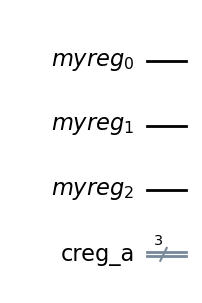

cir_isa is of type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(), dtype=float64>))


In [6]:
## Using Estimator

from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, ParameterVector
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, SamplerV2

qr=QuantumRegister(3, 'myreg')
cr=ClassicalRegister(3, 'creg_a')
qc=QuantumCircuit(qr, cr)
# qc.h(2)
# qc.measure(qr,cr)
# with qc.if_test((cr[2], 1)) as else_:
#     qc.z(1)
# with else_:
#     qc.h(1)

display(qc.draw('mpl'))
sv=QiskitRuntimeService()
backend=sv.backends()[0]
pm=generate_preset_pass_manager(backend=backend, optimization_level=3)
obs=SparsePauliOp('XII')
cir_isa=pm.run(qc)
print('cir_isa is of type', type(cir_isa))
obs_isa=obs.apply_layout(cir_isa.layout)

PUB1=(cir_isa, obs_isa, [], 4)

# estimator=EstimatorV2(mode=backend,shots=4000)
estimator=EstimatorV2(mode=backend)
# job=estimator.run([(cir_isa, obs_isa)])
job=estimator.run([(cir_isa, obs_isa, None, 0.04)])
results=job.result()

print(results[0].data)

In [9]:
## Unroll3qOrMore: Recursively expands 3q+ gates until the circuit only contains 2q or 1q gates.
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroll3qOrMore

pm = PassManager([Unroll3qOrMore(target=backend.target)])  # or basis_gates=[...]
qc_unrolled = pm.run(qc)


In [10]:
from qiskit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroll3qOrMore

# 1) Build a circuit with a 3-qubit gate (ccx)
qc = QuantumCircuit(3, name="before")
qc.ccx(0, 1, 2)   # Toffoli: controls q0,q1; target q2

# 2) Unroll any 3+ qubit gates into 1- and 2-qubit operations
# Choose a basis that includes the standard ccx decomposition primitives
basis = ["cx", "h", "t", "tdg", "s", "sdg", "x"]
pm = PassManager([Unroll3qOrMore(basis_gates=basis)])
qc_after = pm.run(qc)

print("=== BEFORE ===")
print(qc.draw())
print("\n=== AFTER (no 3q+ gates) ===")
print(qc_after.draw())


=== BEFORE ===
          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

=== AFTER (no 3q+ gates) ===
                                                       ┌───┐      
q_0: ───────────────────■─────────────────────■────■───┤ T ├───■──
                        │             ┌───┐   │  ┌─┴─┐┌┴───┴┐┌─┴─┐
q_1: ───────■───────────┼─────────■───┤ T ├───┼──┤ X ├┤ Tdg ├┤ X ├
     ┌───┐┌─┴─┐┌─────┐┌─┴─┐┌───┐┌─┴─┐┌┴───┴┐┌─┴─┐├───┤└┬───┬┘└───┘
q_2: ┤ H ├┤ X ├┤ Tdg ├┤ X ├┤ T ├┤ X ├┤ Tdg ├┤ X ├┤ T ├─┤ H ├──────
     └───┘└───┘└─────┘└───┘└───┘└───┘└─────┘└───┘└───┘ └───┘      


In Qiskit 2.2.x, Unroll3qOrMore expands every 3-qubit-or-larger instruction into 1–2-qubit gates unless that instruction’s name is listed in basis_gates or is natively supported by the provided target—in which case it’s preserved.